<a href="https://colab.research.google.com/github/elizathornton/Risk-Strat/blob/main/First_40_patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn
!pip install -q xlrd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [29]:
# First we need to read a dataframe with an accurate patient list and the features we are using for scoring
# Start with reading in the patient list first test Validation patients
# MRN	TotalScoreNBR	RiskTierNM	TotalCostOfCareAMT
valdata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Validation Patients.csv')


In [30]:
# change the cost column to a number instead of a $
valdata.dropna(axis = 0, inplace = True)
valdata.rename({list(valdata)[3]: 'Cost'}, axis=1, inplace = True)
valdata['Cost'] = valdata['Cost'].str.replace('-','0')
valdata['Cost'] = valdata['Cost'].str.replace(',','')
valdata['Cost'] = valdata['Cost'].str.replace('$','')
valdata['Cost'] = pd.to_numeric(valdata['Cost'],errors='coerce')
valdata.tail()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,MRN,TotalScoreNBR,RiskTierNM,Cost
27,569463,20,Bronze,3041.04
28,216592,37,Silver,2298.60
29,559678,34,Silver,2104.28
30,97291,21,Silver,1526.94
31,282121,27,Silver,0.00


In [23]:
backup = valdata.copy()
backup.head()

,MRN,TotalScoreNBR,RiskTierNM,Cost
0,579573,94,Platinum,235203.64
1,216590,69,Platinum,172528.75
2,396392,71,Platinum,119504.37
3,510587,83,Platinum,112207.78
4,594120,56,Platinum,106769.28


In [31]:
#Read in all the data from Patient Risk Stratification Patient Validation w total cost

# 1) Inpatient and OBS admissions:
# MRN	AlternateID	AdmitDTS	PatientClassCD
iodata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Encounters - Inpatient and OBS.csv')

# 2) ED costs: Patient Risk Stratification Patient Validation w total cost - Encounters - All ED
# MRN	SourceDSC	PatientClassCD	StartDTS	EndDTS	LengthOfStayDayNBR	EmergencyDepartmentFLG	EDVisitWithoutAdmitFLG2	RowNBR																	
eddata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Encounters - All ED.csv')

# 3) Readmission: Patient Risk Stratification Patient Validation w total cost - Readmission
# MRN	PatientClassCD	AdmitDTS	NextAdmitDTS	DaysToNextAdmitNBR	ReadmissionFLG																				
redata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Encounters - Readmission.csv')

# 4) SNF: Patient Risk Stratification Patient Validation w total cost - Claims SNF
#MRN	YearNBR	MonthNBR	SNFStayMonthDTS	StartDTS	EndDTS	CalculatedEndDTS	LengthOfStayDayNBR	ClaimTypeDSC	PatientClassCD	SNFStayRowNBR	SNFFLG														
snfdata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Encounters - Claims SNF.csv')

#5 ) Labs: Patient Risk Stratification Patient Validation w total cost - Labs
# MRN	ObservationNM	ObservationValueTXT	MeasurementUnitNM	ReferenceRangeTXT	AbnormalCD	ResultStatus02CD	ObservationCD	ResultDateTimeDTS																	
labdata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Labs.csv')

# 6) Diagnoses: Patient Risk Stratification Patient Validation w total cost - Diagnoses
# PatientID	MRN	SourceDSC	VisitDTS	DiagnosisCD	DiagnosisDSC	DiseaseCategoryDSC	WeightNBR	RowNBR																	
diagdata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Diagnoses.csv')

# 7) SDOH: Patient Risk Stratification Patient Validation w total cost - SDOH
# MRN	SourceDSC	DualEligibleFLG
sdohdata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test SDOH.csv')

# 3) ADI: Patient Risk Stratification Patient Validation w total cost - Area Deprivation Index
# MRN	ZipCD	ADI	WeightNBR																						
adidata = pd.read_csv('/content/drive/My Drive/VPA Projects/Risk Strat/first test Area Deprivation Index.csv')




In [25]:
adidata.head()

,MRN,ZipCD,ADI,WeightNBR
0,65920,48141 - 2513,100,2
1,580153,48134 - 2752,31,1
2,594120,75067 - 5954,96,2
3,423853,75081 - 2743,46,1
4,558772,53115 - 2927,78,2


In [32]:
# Add SDOH and ADI to valdata
#valdata = backup.copy()

valdata = pd.merge(valdata, sdohdata, how='left', on='MRN')
valdata = pd.merge(valdata, adidata, how='left', on='MRN')
valdata.drop(['SourceDSC','ZipCD','WeightNBR','RiskTierNM'],axis = 1, inplace = True)
valdata.rename({'DualEligibleFLG':'SDOH'},axis = 1 , inplace = True)
valdata['SDOH'] = valdata['SDOH'].str.replace('Y','1')
valdata['SDOH'] = valdata['SDOH'].str.replace('N','0')
valdata['SDOH'] = pd.to_numeric(valdata['SDOH'],errors='coerce')
valdata['SDOH'] = valdata['SDOH'].fillna(0)   # if we don't have any SDOH data set to 0
valdata['ADI'] = pd.to_numeric(valdata['ADI'],errors='coerce')
valdata['ADI'].fillna(value = valdata['ADI'].mean(), inplace = True) # replacing missing ADI with mean ADI


valdata.head()


,MRN,TotalScoreNBR,Cost,SDOH,ADI
0,579573,94,235203.64,1,51.00000
1,216590,69,172528.75,1,65.52381
2,396392,71,119504.37,1,78.00000
3,510587,83,112207.78,1,54.00000
4,594120,56,106769.28,1,96.00000


In [40]:
#backup = valdata.copy()
backup.head()
valdata = backup.copy()

In [41]:
# Add in readmission data

df = redata.groupby('MRN').sum()
df.drop(columns=['DaysToNextAdmitNBR'],inplace=True)
valdata = pd.merge(valdata, df, how='left', on='MRN')
valdata.rename({'ReadmissionFLG':'Readmissions'},axis = 1 , inplace = True)
valdata['Readmissions'].fillna(value = 0, inplace = True) # replacing missing Readmission Data with 0
valdata.head()



,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions
0,579573,94,235203.64,1,51.00000,2.0
1,216590,69,172528.75,1,65.52381,0.0
2,396392,71,119504.37,1,78.00000,2.0
3,510587,83,112207.78,1,54.00000,0.0
4,594120,56,106769.28,1,96.00000,0.0


In [42]:
# Add in SNF data
df = snfdata.groupby('MRN').sum()
df = df[['SNFFLG']]
valdata = pd.merge(valdata, df, how='left', on='MRN')
valdata.rename({'SNFFLG':'SNF'},axis = 1 , inplace = True)
valdata['SNF'].fillna(value = 0, inplace = True) # replacing missing SNF Data with 0
valdata.head()


,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF
0,579573,94,235203.64,1,51.00000,2.0,1.0
1,216590,69,172528.75,1,65.52381,0.0,3.0
2,396392,71,119504.37,1,78.00000,2.0,1.0
3,510587,83,112207.78,1,54.00000,0.0,1.0
4,594120,56,106769.28,1,96.00000,0.0,3.0


In [43]:
# Add in ED and Inpatient Data

df = eddata.fillna(0)
df['Inpatient'] = df['EmergencyDepartmentFLG']* (1 - df['EDVisitWithoutAdmitFLG2'])
df = df.groupby('MRN').sum()
df = df[['EmergencyDepartmentFLG','Inpatient']]
valdata = pd.merge(valdata, df, how='left', on='MRN')
valdata.rename({'EmergencyDepartmentFLG':'ED'},axis = 1 , inplace = True)
valdata['ED'].fillna(value = 0, inplace = True)
valdata['Inpatient'].fillna(value = 0, inplace = True)
valdata.head()



,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient
0,579573,94,235203.64,1,51.00000,2.0,1.0,19.0,9.0
1,216590,69,172528.75,1,65.52381,0.0,3.0,4.0,4.0
2,396392,71,119504.37,1,78.00000,2.0,1.0,13.0,7.0
3,510587,83,112207.78,1,54.00000,0.0,1.0,6.0,3.0
4,594120,56,106769.28,1,96.00000,0.0,3.0,5.0,3.0


In [44]:
backup = valdata.copy()
valdata.head(40)

,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient
0,579573,94,235203.64,1,51.00000,2.0,1.0,19.0,9.0
1,216590,69,172528.75,1,65.52381,0.0,3.0,4.0,4.0
2,396392,71,119504.37,1,78.00000,2.0,1.0,13.0,7.0
3,510587,83,112207.78,1,54.00000,0.0,1.0,6.0,3.0
4,594120,56,106769.28,1,96.00000,0.0,3.0,5.0,3.0
5,582311,46,95994.52,1,60.00000,2.0,0.0,7.0,4.0
6,65920,60,90991.20,1,100.00000,0.0,0.0,5.0,3.0
7,540274,56,71473.72,0,65.52381,0.0,0.0,5.0,1.0
8,415041,59,45965.87,1,65.52381,1.0,2.0,1.0,1.0
9,423853,55,44498.07,1,46.00000,0.0,0.0,2.0,1.0


In [45]:
# Add in lab data
# GFR < 30, Hgb < 7, A1C > 10, BNP > 5,000, PLT < 50, Prealb < 10, Cr > 1.4

df = labdata.copy()
df1 = df[df['ObservationNM'].str.match('GFR')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
# Not going to change NAN to 0, b/c that would make their GFR 0 - -- going to drop NANs
df1.dropna(subset=['ObservationValueTXT'], inplace = True)
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['GFR'] = 0  # make a new column, and set all the values to zero  
df1.loc[df1['ObservationValueTXT'] < 30, 'GFR'] = 1  # if gfr<30, set GFR column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum GFR
df1.loc[df1['GFR'] > 0, 'GFR'] = 1 # any non-zero GFR just set to 1
df1 = df1[['GFR']]  #drop everything but GFR which now show 0 if never below 30, 1 if some value below 30
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['GFR'] = valdata['GFR'].fillna(0)   # any patients we didn't have any GFR data on set to 0
valdata.head(40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient,GFR
0,579573,94,235203.64,1,51.00000,2.0,1.0,19.0,9.0,0.0
1,216590,69,172528.75,1,65.52381,0.0,3.0,4.0,4.0,0.0
2,396392,71,119504.37,1,78.00000,2.0,1.0,13.0,7.0,0.0
3,510587,83,112207.78,1,54.00000,0.0,1.0,6.0,3.0,0.0
4,594120,56,106769.28,1,96.00000,0.0,3.0,5.0,3.0,0.0
5,582311,46,95994.52,1,60.00000,2.0,0.0,7.0,4.0,0.0
6,65920,60,90991.20,1,100.00000,0.0,0.0,5.0,3.0,0.0
7,540274,56,71473.72,0,65.52381,0.0,0.0,5.0,1.0,0.0
8,415041,59,45965.87,1,65.52381,1.0,2.0,1.0,1.0,0.0
9,423853,55,44498.07,1,46.00000,0.0,0.0,2.0,1.0,0.0


In [56]:
backup = valdata.copy()

In [47]:
# Add in lab data
# GFR < 30, Hgb < 7, A1C > 10, BNP > 5,000, PLT < 50, Prealb < 10, Cr > 1.4

df = labdata.copy()
df1 = df[df['ObservationNM'].str.match('Hemoglobin')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
# Not going to change NAN to 0, b/c that would make their hgb 0 - -- going to drop NANs
df1.dropna(subset=['ObservationValueTXT'], inplace = True)
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['Hemoglobin'] = 0  # make a new column, and set all the values to zero  
df1.loc[df1['ObservationValueTXT'] < 7, 'Hemoglobin'] = 1  # if hemoglobin <7 , set hgb column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum hgb
df1.loc[df1['Hemoglobin'] > 0, 'Hemoglobin'] = 1 # any non-zero hgb just set to 1
df1 = df1[['Hemoglobin']]  #drop everything but hgb which now show 0 if never below 7,  1 if some value below 7
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['Hemoglobin'] = valdata['Hemoglobin'].fillna(0)   # any patients we didn't have any GFR data on set to 0
valdata.head(40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient,GFR,Hemoglobin
0,579573,94,235203.64,1,51.00000,2.0,1.0,19.0,9.0,0.0,0.0
1,216590,69,172528.75,1,65.52381,0.0,3.0,4.0,4.0,0.0,0.0
2,396392,71,119504.37,1,78.00000,2.0,1.0,13.0,7.0,0.0,0.0
3,510587,83,112207.78,1,54.00000,0.0,1.0,6.0,3.0,0.0,0.0
4,594120,56,106769.28,1,96.00000,0.0,3.0,5.0,3.0,0.0,0.0
5,582311,46,95994.52,1,60.00000,2.0,0.0,7.0,4.0,0.0,0.0
6,65920,60,90991.20,1,100.00000,0.0,0.0,5.0,3.0,0.0,0.0
7,540274,56,71473.72,0,65.52381,0.0,0.0,5.0,1.0,0.0,0.0
8,415041,59,45965.87,1,65.52381,1.0,2.0,1.0,1.0,0.0,0.0
9,423853,55,44498.07,1,46.00000,0.0,0.0,2.0,1.0,0.0,0.0


In [ ]:
# GFR < 30, Hgb < 7, A1C > 10, BNP > 5,000, PLT < 50, Prealb < 10, Cr > 1.4

df1 = df[df['ObservationNM'].str.contains('A1C')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
# Not going to change NAN to 0, b/c that would make their ha1c 0 - -- going to drop NANs
df1.dropna(subset=['ObservationValueTXT'], inplace = True)
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['A1C'] = 0  # make a new column, and set all the values to zero 
#df1.head(20) 
df1.loc[df1['ObservationValueTXT'] > 10 , 'A1C'] = 1  # if A1C>10 , set  column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum feature column
df1.loc[df1['A1C'] > 0, 'A1C'] = 1 # any non-zero hgb just set to 1
df1 = df1[['A1C']]  #drop everything but ha1c which now show 0 if never above,  1 if some value above 10
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['A1C'].fillna(value = 0, inplace = True)   # any patients we didn't have any GFR data on set to 0
valdata.head(40)

In [ ]:
# GFR < 30, Hgb < 7, A1C > 10, BNP > 5,000, PLT < 50, Prealb < 10, Cr > 1.4

df1 = df[df['ObservationNM'].str.contains('BNP')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
df1.dropna(subset=['ObservationValueTXT'], inplace = True) #  -- going to drop NANs
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['BNP'] = 0  # make a new column, and set all the values to zero 
df1.loc[df1['ObservationValueTXT'] > 5000 , 'BNP'] = 1  # if bnp> 5000 , set  column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum feature column
df1.loc[df1['BNP'] > 0, 'BNP'] = 1 # any non-zero  just set to 1
df1 = df1[['BNP']]  #drop everything but ha1c which now show 0 if never above,  1 if some value above 10
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['BNP'].fillna(value = 0, inplace = True)   # any patients we didn't have any GFR data on set to 0


df1 = df[df['ObservationNM'].str.contains('Platelet')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
df1.dropna(subset=['ObservationValueTXT'], inplace = True) #  -- going to drop NANs
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['PLT'] = 0  # make a new column, and set all the values to zero 
df1.loc[df1['ObservationValueTXT'] < 50 , 'PLT'] = 1  # if plt < 50 , set  column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum feature column
df1.loc[df1['PLT'] > 0, 'PLT'] = 1 # any non-zero  just set to 1
df1 = df1[['PLT']]  #drop everything but ha1c which now show 0 if never above,  1 if some value above 10
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['PLT'].fillna(value = 0, inplace = True)   # any patients we didn't have any GFR data on set to 0


df1 = df[df['ObservationNM'].str.contains('Prealbumin')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
df1.dropna(subset=['ObservationValueTXT'], inplace = True) #  -- going to drop NANs
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['Prealbumin'] = 0  # make a new column, and set all the values to zero 
df1.loc[df1['ObservationValueTXT'] < 10 , 'Prealbumin'] = 1  # if bnp> 5000 , set  column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum feature column
df1.loc[df1['Prealbumin'] > 0, 'Prealbumin'] = 1 # any non-zero  just set to 1
df1 = df1[['Prealbumin']]  #drop everything but prealb which now show 0 if never above,  1 if some value below 10
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['Prealbumin'].fillna(value = 0, inplace = True)   # any patients we didn't have any GFR data on set to 0


df1 = df[df['ObservationNM'].str.contains('Creatinine')]
df1['ObservationValueTXT'] = pd.to_numeric(df1['ObservationValueTXT'],errors='coerce')
df1.dropna(subset=['ObservationValueTXT'], inplace = True) #  -- going to drop NANs
df1 = df1[['MRN','ObservationNM', 'ObservationValueTXT']] # get rid of extra columns
df1['Cr'] = 0  # make a new column, and set all the values to zero 
df1.loc[df1['ObservationValueTXT'] > 1.4 , 'Cr'] = 1  # if bnp> 5000 , set  column value to 1
df1 = df1.groupby('MRN').sum() #collapse values by MRN, sum feature column
df1.loc[df1['Cr'] > 0, 'Cr'] = 1 # any non-zero  just set to 1
df1 = df1[['Cr']]  #drop everything but cr which now show 0 if never above,  1 if some value above 1.4
valdata = pd.merge(valdata, df1, how='left', on='MRN')   # add it on to valdata
valdata['Cr'].fillna(value = 0, inplace = True)   # any patients we didn't have any GFR data on set to 0

valdata.head(40)

In [58]:
backup= valdata.copy()

In [59]:
dxlist = ['CHF', 'COPD / Asthma', 'Diabetes','CKD/ESRD','ESLD','Amputation / Paralysis / Wounds','Gait abnormality; difficulty walking','Malnutrition','Failure to thrive','Cachexia','Debility','History of Fall','Muscle wasting','Muscle weakness','Decubitus ulcer','Senility / Dementia','Durable Medical Equipment (DME)','Acute MI, Ischemic Heart Disease','Heart Arrhythmias','Stroke','Substance Use Disorder','Dementia','RA and Other Inflammatory Tissue Disease','Artificial Openings','Cancer','Cystic Fibrosis','Endocrine and Metabolic Disorders','Inflammatory Bowel Disease','Paralytic Diseases','Skin Ulcer','Liver Disease','Benign Prostatic Hyperplasia (BPH)','Eye Disease','Hyperlipidemia (HLD)','Hypertension','Osteoporosis','Thyroid Disease'
]
print(dxlist)

['CHF', 'COPD / Asthma', 'Diabetes', 'CKD/ESRD', 'ESLD', 'Amputation / Paralysis / Wounds', 'Gait abnormality; difficulty walking', 'Malnutrition', 'Failure to thrive', 'Cachexia', 'Debility', 'History of Fall', 'Muscle wasting', 'Muscle weakness', 'Decubitus ulcer', 'Senility / Dementia', 'Durable Medical Equipment (DME)', 'Acute MI, Ischemic Heart Disease', 'Heart Arrhythmias', 'Stroke', 'Substance Use Disorder', 'Dementia', 'RA and Other Inflammatory Tissue Disease', 'Artificial Openings', 'Cancer', 'Cystic Fibrosis', 'Endocrine and Metabolic Disorders', 'Inflammatory Bowel Disease', 'Paralytic Diseases', 'Skin Ulcer', 'Liver Disease', 'Benign Prostatic Hyperplasia (BPH)', 'Eye Disease', 'Hyperlipidemia (HLD)', 'Hypertension', 'Osteoporosis', 'Thyroid Disease']


In [61]:
diagdata.head()

,PatientID,MRN,SourceDSC,VisitDTS,DiagnosisCD,DiagnosisDSC,DiseaseCategoryDSC,WeightNBR,RowNBR,Unnamed: 9
0,{89B5230B-C8F7-4F3A-BAD7-4298198F09D0},65920.0,Claim,11/30/2020,86,Acute Myocardial Infarction,"Acute MI, Ischemic Heart Disease",2.0,1.0,2.0
1,{89B5230B-C8F7-4F3A-BAD7-4298198F09D0},65920.0,Claim,11/30/2020,87,Unstable Angina and Other Acute Ischemic Heart...,"Acute MI, Ischemic Heart Disease",2.0,2.0,NaN
2,{89B5230B-C8F7-4F3A-BAD7-4298198F09D0},65920.0,Aprima,5/19/2022,85,NaN,CHF,6.0,1.0,6.0
3,{89B5230B-C8F7-4F3A-BAD7-4298198F09D0},65920.0,Aprima,9/16/2022,136,NaN,CKD/ESRD,6.0,1.0,6.0
4,{89B5230B-C8F7-4F3A-BAD7-4298198F09D0},65920.0,Claim,1/1/2022,134,Dialysis Status,CKD/ESRD,6.0,2.0,NaN


In [66]:
backup = valdata.copy()

In [90]:
# now we are going to go through all the dx  and just give a patient a 1 if they have that dx and a 0 if they don't

df = diagdata[['MRN','DiseaseCategoryDSC']]
#df1 = valdata[['MRN']]
for i in dxlist:
   # make a column in df with the column name the dx category default set to 0
  df[i] = 0
  df.loc[df["DiseaseCategoryDSC"] == i, i] = 1 # set the value to 1 if DiseaseCategoryDSC = dx

# Ditch column DiseaseCategoryDSC
df.drop(['DiseaseCategoryDSC'], axis = 1, inplace = True)

# collapse the dataframe by MRN, summing all of the columns for each MRN
df = df.groupby('MRN').sum()
# set any value > 1 to 1 (just counting if we have the dx, not how many times)
df.mask(df != 0, 1, inplace = True)
# add the df to valdata

# set NANs = 0 (assume we don't have the dx if no data)

df.head()
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CHF,COPD / Asthma,Diabetes,CKD/ESRD,ESLD,Amputation / Paralysis / Wounds,Gait abnormality; difficulty walking,Malnutrition,Failure to thrive,Cachexia,...,Inflammatory Bowel Disease,Paralytic Diseases,Skin Ulcer,Liver Disease,Benign Prostatic Hyperplasia (BPH),Eye Disease,Hyperlipidemia (HLD),Hypertension,Osteoporosis,Thyroid Disease
MRN,,,,,,,,,,,,,,,,,,,,,
65920.0,1,1,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
97291.0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
154214.0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
216590.0,1,1,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,1,1,0,0
216592.0,1,0,1,0,0,0,1,0,0,0,...,0,1,1,0,0,0,1,1,1,0


In [91]:
valdata = pd.merge(valdata, df, how='left', on='MRN') 
valdata.head()

,MRN,TotalScoreNBR,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient,GFR,...,Inflammatory Bowel Disease,Paralytic Diseases,Skin Ulcer,Liver Disease,Benign Prostatic Hyperplasia (BPH),Eye Disease,Hyperlipidemia (HLD),Hypertension,Osteoporosis,Thyroid Disease
0,579573,94,235203.64,1,51.00000,2.0,1.0,19.0,9.0,0.0,...,0,1,1,0,1,0,1,1,0,0
1,216590,69,172528.75,1,65.52381,0.0,3.0,4.0,4.0,0.0,...,0,1,1,0,1,0,1,1,0,0
2,396392,71,119504.37,1,78.00000,2.0,1.0,13.0,7.0,0.0,...,1,1,1,0,0,0,1,1,1,0
3,510587,83,112207.78,1,54.00000,0.0,1.0,6.0,3.0,0.0,...,1,1,1,1,0,0,1,1,1,0
4,594120,56,106769.28,1,96.00000,0.0,3.0,5.0,3.0,0.0,...,0,1,1,0,0,0,1,1,0,0


In [92]:
backup = valdata.copy()

In [93]:
valdata.to_csv('valdata.csv') 


In [95]:
valdata.shape

(32, 53)

In [96]:
valdata.drop(['TotalScoreNBR'], axis= 1, inplace = True)

In [98]:
valdata = valdata.set_index('MRN')
valdata.head()

,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient,GFR,Hemoglobin,A1C,...,Inflammatory Bowel Disease,Paralytic Diseases,Skin Ulcer,Liver Disease,Benign Prostatic Hyperplasia (BPH),Eye Disease,Hyperlipidemia (HLD),Hypertension,Osteoporosis,Thyroid Disease
MRN,,,,,,,,,,,,,,,,,,,,,
579573,235203.64,1,51.00000,2.0,1.0,19.0,9.0,0.0,0.0,0.0,...,0,1,1,0,1,0,1,1,0,0
216590,172528.75,1,65.52381,0.0,3.0,4.0,4.0,0.0,0.0,0.0,...,0,1,1,0,1,0,1,1,0,0
396392,119504.37,1,78.00000,2.0,1.0,13.0,7.0,0.0,0.0,0.0,...,1,1,1,0,0,0,1,1,1,0
510587,112207.78,1,54.00000,0.0,1.0,6.0,3.0,0.0,0.0,0.0,...,1,1,1,1,0,0,1,1,1,0
594120,106769.28,1,96.00000,0.0,3.0,5.0,3.0,0.0,0.0,0.0,...,0,1,1,0,0,0,1,1,0,0


In [99]:
valdata['ADI'] = valdata['ADI'] / 100
valdata.head()

,Cost,SDOH,ADI,Readmissions,SNF,ED,Inpatient,GFR,Hemoglobin,A1C,...,Inflammatory Bowel Disease,Paralytic Diseases,Skin Ulcer,Liver Disease,Benign Prostatic Hyperplasia (BPH),Eye Disease,Hyperlipidemia (HLD),Hypertension,Osteoporosis,Thyroid Disease
MRN,,,,,,,,,,,,,,,,,,,,,
579573,235203.64,1,0.510000,2.0,1.0,19.0,9.0,0.0,0.0,0.0,...,0,1,1,0,1,0,1,1,0,0
216590,172528.75,1,0.655238,0.0,3.0,4.0,4.0,0.0,0.0,0.0,...,0,1,1,0,1,0,1,1,0,0
396392,119504.37,1,0.780000,2.0,1.0,13.0,7.0,0.0,0.0,0.0,...,1,1,1,0,0,0,1,1,1,0
510587,112207.78,1,0.540000,0.0,1.0,6.0,3.0,0.0,0.0,0.0,...,1,1,1,1,0,0,1,1,1,0
594120,106769.28,1,0.960000,0.0,3.0,5.0,3.0,0.0,0.0,0.0,...,0,1,1,0,0,0,1,1,0,0


In [101]:
y = valdata['Cost']
x = valdata.drop(['Cost'], axis= 1)
linreg = LinearRegression()
linreg.fit(x,y)

LinearRegression()

In [115]:
y_pred = linreg.predict(x)
df_preds = pd.DataFrame({'Actual Cost': y, 'Predicted Cost Base on Scoring with Multivariant Linear Regression': y_pred.squeeze()})
print(df_preds)

        Actual Cost  \
MRN                   
579573    235203.64   
216590    172528.75   
396392    119504.37   
510587    112207.78   
594120    106769.28   
582311     95994.52   
65920      90991.20   
540274     71473.72   
415041     45965.87   
423853     44498.07   
488967     44420.84   
580153     43255.30   
525671     38049.81   
555546     36441.77   
570511     35844.11   
565059     30596.79   
557082     29933.88   
571249     23205.51   
533448     22680.72   
475319     14487.34   
528310     13929.11   
505584     10773.42   
546319     10192.51   
392862     10186.07   
558772      9234.89   
154214      5253.40   
588077      4413.01   
569463      3041.04   
216592      2298.60   
559678      2104.28   
97291       1526.94   
282121         0.00   

        Predicted Cost Base on Scoring with Multivariant Linear Regression  
MRN                                                                         
579573                                       2.352036e+05      

In [107]:
scoring = linreg.coef_


In [109]:
scoref= scoring.astype('float64')
print(scoref)

[ 7.96959055e+02  6.13736063e+03 -9.25748481e+03  9.52942967e+03
  2.13267508e+03  1.29047548e+04 -2.85902322e+04 -7.27595761e-12
 -1.53741738e+04  3.63797881e-12 -1.81898940e-12  6.36646291e-12
 -1.40530085e+03  9.24305955e+02  8.59024110e+03  1.29640601e+03
  1.01040474e+04  7.27595761e-12  1.21437605e+04  1.44132782e+04
  7.04858394e-12 -1.05663517e+04  0.00000000e+00 -4.00513088e+03
  1.50768148e+03  2.11476506e+04  7.91039326e+02 -4.61926930e+03
  1.72130645e+03 -3.05114072e+02  8.02675819e+03  8.91078058e+03
  1.38400024e+04  6.58591687e+03  7.62548483e+03 -5.89057873e+03
  7.68953012e+03  1.08664552e+03 -2.38656010e+04  1.24069673e+03
 -1.12332731e+04 -1.01745117e+03 -7.46681020e+03 -7.48307527e+03
  2.17419908e+04  2.17093631e+03 -3.28270367e+03 -5.18326477e+03
 -1.73890576e+04  0.00000000e+00]


In [110]:
flist = x.columns.values.tolist()
print(flist)

['SDOH', 'ADI', 'Readmissions', 'SNF', 'ED', 'Inpatient', 'GFR', 'Hemoglobin', 'A1C', 'BNP', 'PLT', 'Prealbumin', 'Cr', 'CHF', 'COPD / Asthma', 'Diabetes', 'CKD/ESRD', 'ESLD', 'Amputation / Paralysis / Wounds', 'Gait abnormality; difficulty walking', 'Malnutrition', 'Failure to thrive', 'Cachexia', 'Debility', 'History of Fall', 'Muscle wasting', 'Muscle weakness', 'Decubitus ulcer', 'Senility / Dementia', 'Durable Medical Equipment (DME)', 'Acute MI, Ischemic Heart Disease', 'Heart Arrhythmias', 'Stroke', 'Substance Use Disorder', 'Dementia', 'RA and Other Inflammatory Tissue Disease', 'Artificial Openings', 'Cancer', 'Cystic Fibrosis', 'Endocrine and Metabolic Disorders', 'Inflammatory Bowel Disease', 'Paralytic Diseases', 'Skin Ulcer', 'Liver Disease', 'Benign Prostatic Hyperplasia (BPH)', 'Eye Disease', 'Hyperlipidemia (HLD)', 'Hypertension', 'Osteoporosis', 'Thyroid Disease']


In [112]:
newscoredf = pd.DataFrame()
newscoredf['Features'] = flist
newscoredf['Weights'] = scoref.tolist()
newscoredf.head()

,Features,Weights
0,SDOH,796.959055
1,ADI,6137.360627
2,Readmissions,-9257.484809
3,SNF,9529.429666
4,ED,2132.675076


In [113]:
newscoredf.to_csv('newscore.csv') 

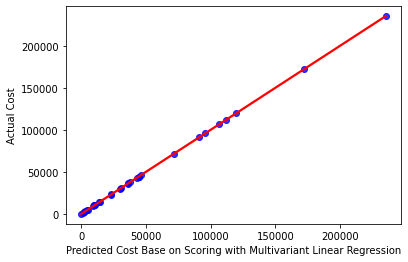

In [117]:
# draw regplot
sns.regplot(x = "Predicted Cost Base on Scoring with Multivariant Linear Regression",
            y = "Actual Cost",
            data = df_preds,
            scatter_kws={"color": "blue"}, line_kws={"color": "red"}
)

plt.ticklabel_format(style='plain', axis='y')  
# show ther plot
plt.show()